In [1]:
import os
import sqlite3
import pandas as pd
import numpy as np
import datetime
import re
import nltk
import pickle
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

conn = sqlite3.connect(r"../../diplom.db")
cur = conn.cursor()

In [17]:
# res = cur.execute("""SELECT ID, DDATE, TRANSCRIPT, DEMOCRACY_COUNT FROM ECHO ORDER BY DEMOCRACY_COUNT DESC LIMIT 25;""")
# for i, date, text, count in res:
#     print(i, date, count)
#     with open(f'{i}.txt', 'w', encoding='utf-8') as f:
#         f.write(text)

In [2]:
corpus = [text[0].split() for text in cur.execute("""select CLEAN_TEXT from ECHO;""").fetchall()]
graph = [i[0] for text in corpus for i in nltk.bigrams(text) if i[1] == "демократия"]
c = Counter(graph)
adjusting = pd.DataFrame(c.most_common()).rename(columns={0: "Слово", 1: "Количество"})
adjusting["Часть"] = [i[1] for i in nltk.pos_tag(adjusting["Слово"], lang="rus")]
adj = adjusting[adjusting["Часть"].isin(["A=m", "A-PRO=m"])].reset_index(drop=True)
s = adj["Количество"].sum()
adj["Процент"] = round(adj["Количество"]/s*100, 2)

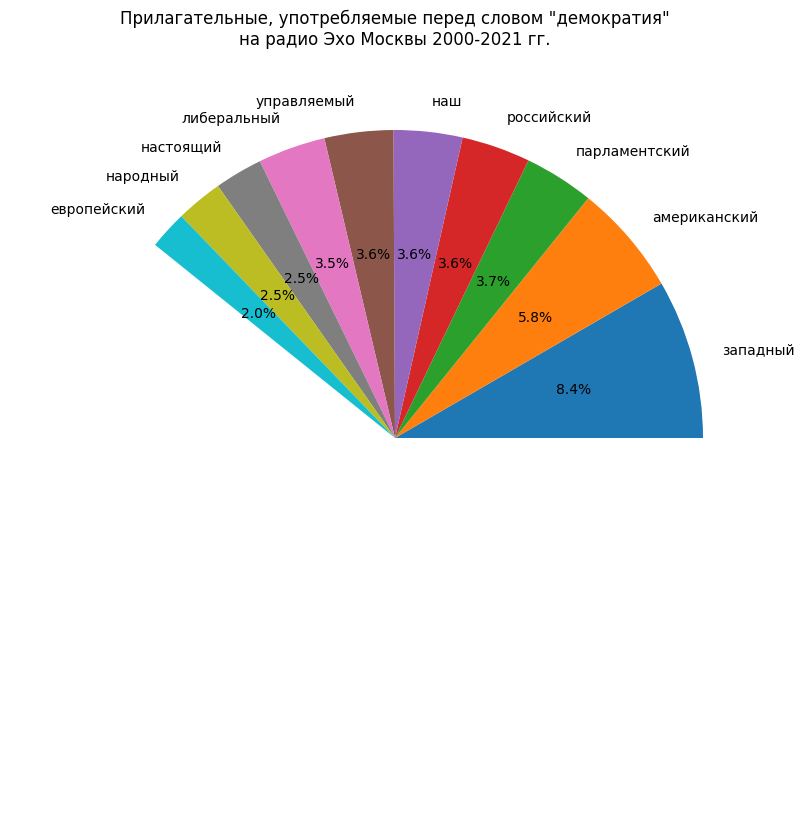

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10, forward=True)
rus = adj[["Слово", "Процент"]].head(10)
rus.loc[10, "Слово"] = "Ост."
rus.loc[10, "Процент"] = adj.loc[10:, "Процент"].sum()
wedge, text, procent = ax.pie(rus["Процент"], labels=rus["Слово"], autopct='%1.1f%%')
wedge[10].set_visible(False)
text[10].set_visible(False)
procent[10].set_visible(False)
ax.set_title('Прилагательные, употребляемые перед словом "демократия"\nна радио Эхо Москвы 2000-2021 гг.')
fig.savefig("echo_adj_ru.png")

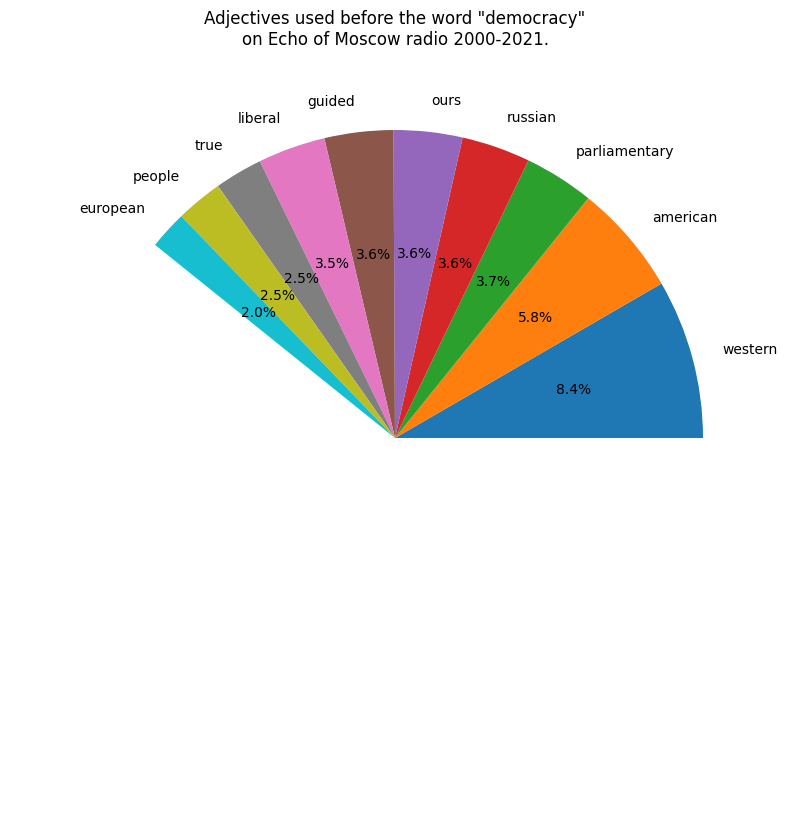

In [16]:
eng = rus.copy()
eng['Word'] = ['western', 'american', 'parliamentary', 'russian', 'ours', 'guided', 'liberal', 'true', 'people', 'european', 'rest']
fig, ax = plt.subplots()
fig.set_size_inches(10, 10, forward=True)
wedge, text, procent = ax.pie(rus["Процент"], labels=eng["Word"], autopct='%1.1f%%')
wedge[10].set_visible(False)
text[10].set_visible(False)
procent[10].set_visible(False)
ax.set_title('Adjectives used before the word "democracy"\non Echo of Moscow radio 2000-2021.')
fig.savefig("echo_adj_en.png")

In [3]:
corpus = [text[0].split() for text in cur.execute("""select CLEAN_TEXT from ECHO""").fetchall()]
model = Word2Vec(corpus, 
                 vector_size=1024,      # embedding vector size
                 min_count=2,
                 window=5).wv
model.save("echo.model")
model.most_similar('демократия')

[('авторитаризм', 0.5756835341453552),
 ('диктатура', 0.5367075800895691),
 ('тирания', 0.5231553316116333),
 ('либерализм', 0.5187169909477234),
 ('народовластие', 0.5184821486473083),
 ('демократический', 0.5148246884346008),
 ('автократия', 0.5025543570518494),
 ('парламентаризм', 0.49467769265174866),
 ('тоталитаризм', 0.4654422700405121),
 ('суверенный', 0.4518289566040039)]

In [18]:
cur.close()
conn.close()